In [28]:
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import BatchSampler
import numpy as np
from torchvision import models
from pytorch_metric_learning import losses
import umap
import matplotlib.pyplot as plt
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from sklearn.metrics import accuracy_score
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

main_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=transform)

## data split and balancing test

In [3]:
train_indices, val_indices,_,_ = train_test_split(range(len(main_dataset.data)), main_dataset.targets, stratify=main_dataset.targets, test_size=0.8, random_state=42)
train_dataset = Subset(main_dataset, train_indices)
val_dataset = Subset(main_dataset, val_indices)

In [4]:
# testing stratification
train_labels = torch.tensor([x[1] for x in train_dataset])
unique_values, counts = train_labels.unique(return_counts=True)
unique_values

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## BalancedBatchSampler

In [2]:
class BalancedBatchSampler(BatchSampler):
    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels =torch.LongTensor([x[1] for x in loader])
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0] for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])

        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size


In [6]:
# create batches
val_loader = DataLoader(val_dataset, batch_size=60)
train_loader = DataLoader(train_dataset, batch_sampler=BalancedBatchSampler(train_dataset, 10, 6))
test_loader = DataLoader(test_dataset, batch_size=60)

## ResNet18

In [3]:
# Define ResNet18 model
class ResNet18(models.ResNet):
    def __init__(self, num_classes=10, is_classifer:bool = True):
        super().__init__(models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=num_classes)
        self.is_classifier = is_classifer
        # self.fc = nn.Linear(512, num_classes)
    def forward(self, x,d=0):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        backbone = torch.flatten(x, 1)
        x = self.fc(backbone)
        if d==0:
            return x
        if d==1:
            return backbone
            # m = nn.Softmax(1)
            # x = m(x)
        return x, backbone



In [19]:
model = ResNet18(is_classifer=True).to(device)

In [20]:
model.load_state_dict(torch.load('./resnet.pth'))

<All keys matched successfully>

In [4]:
# loss_fn = losses.AngularLoss(40)
loss_fn = nn.CrossEntropyLoss() # TODO: change this

optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


NameError: name 'model' is not defined

In [10]:
for epoch in range(2):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    correct_train = 0
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        # logits=torch.argmax(logits,dim=1)

        loss = loss_fn(logits, targets) 
        loss.backward()
        # print(logits)
        optimizer.step()
        # correct_train += (torch.argmax(logits,dim=1) == targets).float().sum()
        accuracy_train = accuracy_score(targets.detach().numpy(), torch.argmax(logits,dim=1).detach().numpy())
        
        train_loss += loss.item()
    model.eval()
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model(inputs)
        # logits=logits.argmax(logits,dim=1)
        loss = loss_fn(logits, targets)
        val_loss += loss.item()
        accuracy = accuracy_score(targets.detach().numpy(),torch.argmax(logits,dim=1).detach().numpy())
        # correct += (torch.argmax(logits,dim=1) == targets).float().sum()
        # accuracy = 100 * correct / len(val_loader)
       

    print(f'{epoch + 1} train loss: {train_loss / len(train_loader)} train accuracy: {accuracy_train} val loss: {val_loss / len(val_loader)} val accuracy: {accuracy}')


KeyboardInterrupt: 

In [11]:
for epoch in range(1):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    test_loss = 0.0
    model.eval()
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits= model(inputs)
        loss = loss_fn(logits, targets)
        val_loss += loss.item()
        accuracy = accuracy_score(targets.detach().numpy(),torch.argmax(logits,dim=1).detach().numpy())
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits= model(inputs)
        loss = loss_fn(logits, targets)
        test_loss += loss.item()
        accuracy_test = accuracy_score(targets.detach().numpy(),torch.argmax(logits,dim=1).detach().numpy())  
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits= model(inputs)
        loss = loss_fn(logits, targets)
        train_loss += loss.item()
        accuracy_train = accuracy_score(targets.detach().numpy(),torch.argmax(logits,dim=1).detach().numpy())
    print(f'train loss: {train_loss / len(train_loader)} train accuracy: {accuracy_train} val loss: {val_loss / len(val_loader)} val accuracy: {accuracy} test loss: {test_loss / len(test_loader)} test accuracy: {accuracy_test}')

train loss: 0.06124671974432576 train accuracy: 1.0 val loss: 2.0711835183125027 val accuracy: 0.65 test loss: 2.063182214776913 test accuracy: 0.525


In [18]:
PATH = './resnet.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint)

NameError: name 'model' is not defined

In [ ]:
# PATH = './resnet.pth'
# torch.save(model.state_dict(), PATH)

In [11]:
x_test = torch.stack([x[0] for x in test_dataset])

In [12]:
y_test = torch.tensor([x[1] for x in test_dataset])

In [18]:
test_embeddings = model.to('cpu')(x_test,1).to(device)

In [19]:
test_embeddings.shape

torch.Size([10000, 512])

In [24]:
umap_reducer = umap.UMAP(n_components=2)
x_umap = umap_reducer.fit_transform(test_embeddings.detach().cpu().numpy())

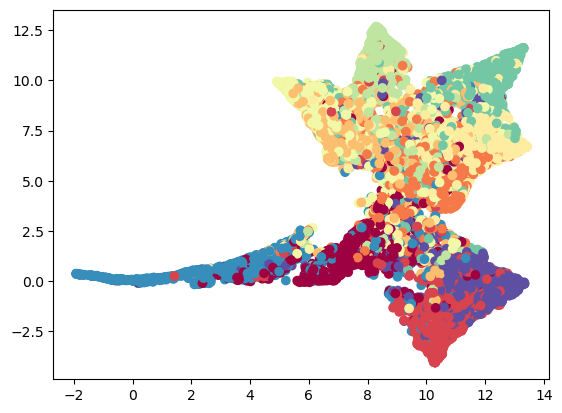

In [25]:
fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
# ax.scatter(x_umap[:,0], x_umap[:,1], x_umap[:,2],c=y_test)
ax.scatter(x_umap[:,0], x_umap[:,1],c=y_test, cmap='Spectral')

In [5]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    AddGaussianNoise(mean=0.0, std=0.1),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [7]:
main_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False,download=False, transform=transform)

In [8]:
train_indices, val_indices,_,_ = train_test_split(range(len(main_dataset.data)), main_dataset.targets, stratify=main_dataset.targets, test_size=0.8, random_state=42)
train_dataset = Subset(main_dataset, train_indices)
val_dataset = Subset(main_dataset, val_indices)

In [58]:
# testing stratification
train_labels = torch.tensor([x[1] for x in train_dataset])
unique_values, counts = train_labels.unique(return_counts=True)
unique_values

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
x_test = torch.stack([x[0] for x in test_dataset])
y_test = torch.tensor([x[1] for x in test_dataset])
# _,test_embeddings = model.to('cpu')(x_test)

In [25]:
x_train = torch.stack([x[0] for x in train_dataset]).to(device)
y_train = torch.tensor([x[1] for x in train_dataset]).to(device)


In [27]:
import cleverhans

fgsm = fast_gradient_method(model,x_test,eps=0.3,norm=np.inf)
# acc = model.evaluate(fgsm, y_test)[1]
# print(f"Accuracy on train data: {acc}")

In [36]:
test_embeddings_atk = model.to('cpu')(fgsm,1)

In [37]:
umap_reducer = umap.UMAP(n_components=2)
x_umap = umap_reducer.fit_transform(test_embeddings_atk.detach().cpu().numpy())

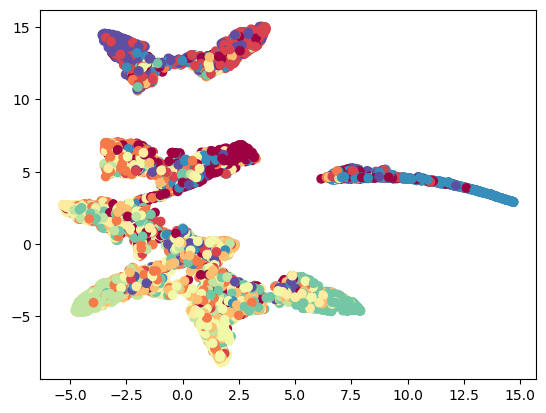

In [38]:
fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
# ax.scatter(x_umap[:,0], x_umap[:,1], x_umap[:,2],c=y_test)
ax.scatter(x_umap[:,0], x_umap[:,1],c=y_test, cmap='Spectral')

In [30]:
fgsm_train = fast_gradient_method(model.to('cpu'),x_train.to('cpu'),eps=0.3,norm=np.inf)
fgsm_dataset = TensorDataset(fgsm_train, y_train.to('cpu'))
train_loader = DataLoader(fgsm_dataset, batch_sampler=BalancedBatchSampler(fgsm_dataset, 10, 6))

In [70]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([60, 3, 32, 32])
torch.Size([60])


In [34]:
device = torch.device('cpu')
model_adv = ResNet18(is_classifer=True).to(device)

In [35]:
loss_fn = nn.CrossEntropyLoss() # TODO: change this
optimizer = optim.Adam(model_adv.parameters())

In [36]:
for epoch in range(15):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    correct_train = 0
    model_adv.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits = model_adv(inputs)
        # logits=torch.argmax(logits,dim=1)

        loss = loss_fn(logits, targets)
        loss.backward()
        # print(logits)
        optimizer.step()
        # correct_train += (torch.argmax(logits,dim=1) == targets).float().sum()
        # accuracy_train = accuracy_score(targets.detach().cpu().numpy(), torch.argmax(logits,dim=1).detach().cpu().numpy())
        train_loss += loss.item()
    model_adv.eval()
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        logits = model_adv(inputs)
        # logits=logits.argmax(logits,dim=1)
        loss = loss_fn(logits, targets)
        val_loss += loss.item()
        # accuracy = accuracy_score(targets.detach().cpu().numpy(),torch.argmax(logits,dim=1).detach().cpu().numpy())
        # correct += (torch.argmax(logits,dim=1) == targets).float().sum()
        # accuracy = 100 * correct / len(val_loader)
    accuracy_train = 0
    accuracy = 0
    print(f'{epoch + 1} train loss: {train_loss / len(train_loader)} train accuracy: {accuracy_train} val loss: {val_loss / len(val_loader)} val accuracy: {accuracy}')

KeyboardInterrupt: 